In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

import data
import train
import plot
import torch

/home/maarten/Documents/masterthesis/supervised


In [8]:
num_clusters = 5

files = [f'../clusterlabeled-{num_clusters}/1800{i}.xml' for i in [1, 2, 3, 4, 5]]
dataset = data.GermanDatasetInMemory(files, num_clusters, 300, 700, 3, 0)

Loading samples:  48%|████▊     | 17161/35764 [05:20<05:47, 53.52it/s] 


In [9]:
traindata, testdata = dataset.split(0.3)

params = train.CNNParams(
    embed_size=300,
    dropout=0.25,
    epochs=100,
    num_filters=100
)

optimizer = lambda params: torch.optim.Adadelta(params, weight_decay=0.001)
model, losses = train.setup_and_train(params, with_labels=False, dataset=traindata,
                                      epochs=params.epochs, batch_size=50, optim_fn=optimizer)
label_model, label_losses = train.setup_and_train(params, with_labels=True,
                                                  dataset=traindata, epochs=params.epochs,
                                                  batch_size=50, optim_fn=optimizer)

Training: 100%|██████████| 100/100 [00:35<00:00,  2.80it/s, loss=0.182, Δloss=0.0208] 


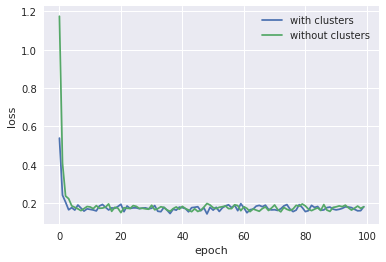

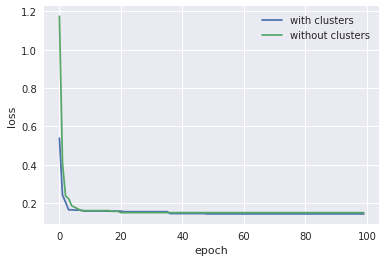

In [10]:
plot.plot({'with clusters': label_losses, 'without clusters': losses}, False)
plot.plt.figure()
plot.plot({'with clusters': label_losses, 'without clusters': losses}, True)

In [12]:
print('Without clusters:')
train.evaluate_clf(model, data.get_iterator(testdata, [40]))
print('With clusters:')
train.evaluate_clf(label_model, data.get_iterator(testdata, [40]))

Without clusters:

----------------  --------
f1                0.978723
Speech recall     1
Speech precision  0.958333
----------------  --------
With clusters:

----------------  --------
f1                0.983957
Speech recall     1
Speech precision  0.968421
----------------  --------


(0.968421052631579, 1.0, 0.983957219251337)